In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
import torch

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = '../input/flickr8k/Images'

In [3]:
data = pd.read_csv("../input/flickr8k/captions.txt")#data là dạng text, chứa link đến image và text caption
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
##Lấy thử 15 ảnh ra để quan sát dữ liệu
def readImage(path,img_size=224):#Hàm lấy ảnh từ tập image
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))#Kích thước ảnh là 224x224
    img = img_to_array(img)#Chuyển image -> array
    img = img/255.#chuẩn hóa các pixel về (0,1)
    return img

def display_images(temp_df):#Biểu diễn ảnh với caption của nó
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


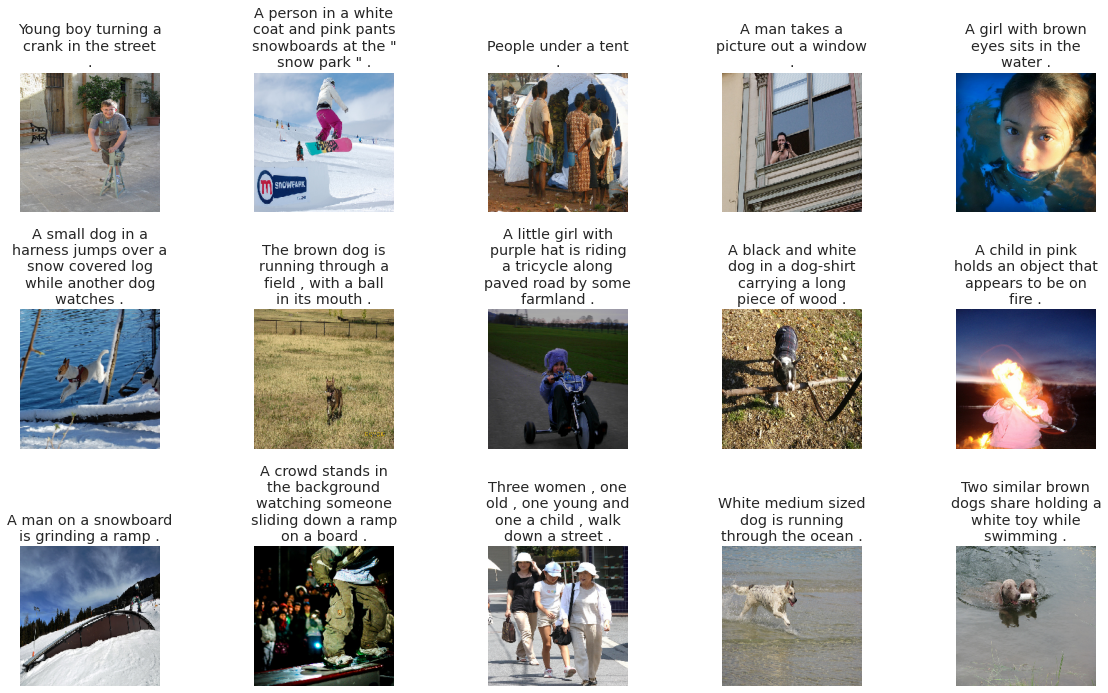

In [5]:
display_images(data.sample(15))

In [6]:
#Làm sạch dữ liệu caption text
def text_preprocessing(data):
    #thực hiện làm sạch dữ liệu
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) 
    data['caption'] = "startseq "+data['caption']+" endseq"#Thêm startseq và endseq
    return data

In [7]:
data = text_preprocessing(data)#sau khi đã xử lý caption của data
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
#Tách text của caption ra thành các token, đồng thời tạo từ điển
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_length = max(len(caption.split()) for caption in captions)


#Chia dữ liệu vào các tập train, test theo tên file ảnh
images = data['image'].unique().tolist()
nimages = len(images)
#print(images)

split_index = round(0.8*nimages)#lấy random 85% train, 15% test
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

#In ra caption của ảnh khi caption này đã đưa về biểu diễn ở dạng vector
print (tokenizer.texts_to_sequences([captions[1]])[0])
print(tokenizer.texts_to_sequences([captions[5]])[0])
print(tokenizer.texts_to_sequences([captions[7]])[0])

8485
[1, 18, 315, 63, 195, 116, 2]
[1, 14, 8, 7, 842, 8, 16, 342, 2]
[1, 14, 8, 7, 13, 8, 9, 26, 1000, 16, 639, 21, 136, 81, 3, 4, 71, 2]


In [9]:
print(data['image'])
print(data['caption'])

0        1000268201_693b08cb0e.jpg
1        1000268201_693b08cb0e.jpg
2        1000268201_693b08cb0e.jpg
3        1000268201_693b08cb0e.jpg
4        1000268201_693b08cb0e.jpg
                   ...            
40450     997722733_0cb5439472.jpg
40451     997722733_0cb5439472.jpg
40452     997722733_0cb5439472.jpg
40453     997722733_0cb5439472.jpg
40454     997722733_0cb5439472.jpg
Name: image, Length: 40455, dtype: object
0        startseq child in pink dress is climbing up se...
1          startseq girl going into wooden building endseq
2        startseq little girl climbing into wooden play...
3        startseq little girl climbing the stairs to he...
4        startseq little girl in pink dress going into ...
                               ...                        
40450    startseq man in pink shirt climbs rock face en...
40451    startseq man is rock climbing high in the air ...
40452    startseq person in red shirt climbing up rock ...
40453            startseq rock climber in 

In [10]:
#bước này load ảnh, xử lý ảnh 
#Sử dụng pretrained model DenseNet, model này đã được train trên tập DL lớn để đưa từ ảnh qua 1 loạt các convolutional layers và poolong max layers,...
#Tạo ra vector biểu diễn cho ảnh đó
#Đây cũng chính là ENCODER của mô hình - image embeddings
model = ResNet50()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {} #Dictionary được sử dụng để lưu trữ các đặc trưng trích xuất từ các ảnh.
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))#Đường dẫn tới các file ảnh
    ##Chuyển ảnh sang array và chuẩn hóa
    img = img_to_array(img)
    img = img/255.
    #Mở rộng chiều để phù hợp với kích thước đầu vào của model (là batch, nhưng mình đang chỉ quét qua từng ảnh)
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)#đoán ra tất cả các đặc trưng từ ảnh
    features[image] = feature

102981632/102967424 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [07:36<00:00, 17.72it/s]


In [11]:
print(features[data['image'][0]])#In thử ra các đặc trưng của ảnh đầu tiên
print(features[data['image'][0]].shape)#1920 là kích thước vector đầu ra

[[0.         0.         0.00738457 ... 2.5648344  0.         0.        ]]
(1, 2048)


In [12]:
##Hàm tạo ra batches of data for training
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0] #Đảm bảo kích thước đầu vào cố định
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]#Đầu ra là 1 one - hot encoding (dựa theo softmax trước đó)
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [13]:
##Thiết kế cho DECODER - caption model; from word embedding to text
input1 = Input(shape=(2048,))#
input2 = Input(shape=(max_length,))

#Tại sau linear - Thực chất img_features chính là hidden states.
img_features = Dense(256, activation='relu')(input1)#vector đặc trưng (trạng thái hiện tại)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)# batch_size = 1 để phù hợp đầu vào LSTM

#Từ được tạo ra trước đó sẽ được embed, rồi kết hợp với đặc trưng của ảnh ở thời điểm hiện tại (trạng thái hiện tại) để tạo ra word mới.
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1) 

#Drop-out sẽ làm mất mát 1 phần dữ liệu (ko đọc dữ liệu từ 1 số đặc trưng)
sentence_features = LSTM(256)(merged)#Trạng thái hiện tại
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)#Dense bằng softmax activation để dự đoán từ hiện tại

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [14]:
from tensorflow.keras.utils import plot_model

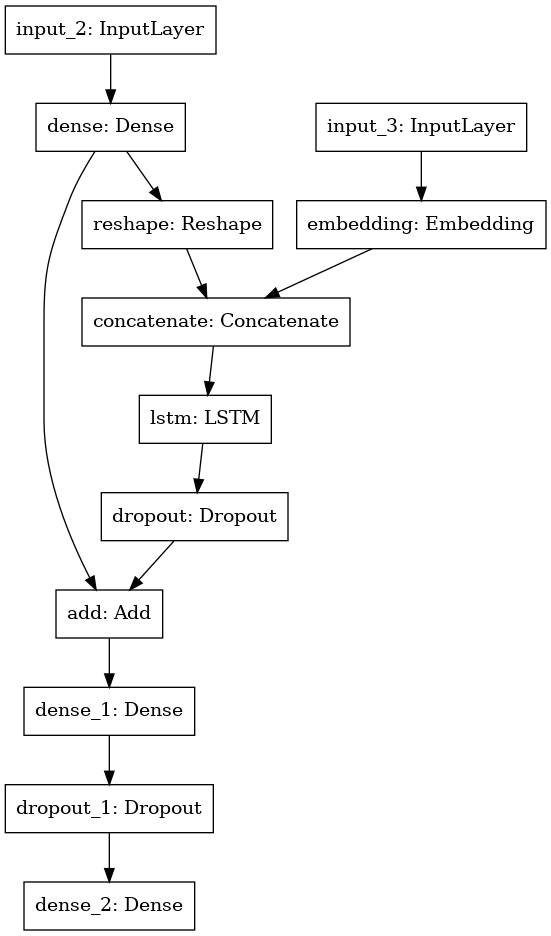

In [15]:
plot_model(caption_model)

In [16]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 256)       0           dense[0][0]                      
____________________________________________________________________________________________

In [17]:
##Tạo các batch dữ liệu train và test
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [18]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

In [19]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])
#dừng sớm khi validation không giảm nữa

Epoch 1/50
505/505 [==============================] - 219s 428ms/step - loss: 5.3755 - val_loss: 4.6201

Epoch 00001: val_loss improved from inf to 4.62007, saving model to model.h5
Epoch 2/50
505/505 [==============================] - 46s 91ms/step - loss: 4.5522 - val_loss: 4.2962

Epoch 00002: val_loss improved from 4.62007 to 4.29618, saving model to model.h5
Epoch 3/50
505/505 [==============================] - 46s 90ms/step - loss: 4.3134 - val_loss: 4.1633

Epoch 00003: val_loss improved from 4.29618 to 4.16330, saving model to model.h5
Epoch 4/50
505/505 [==============================] - 46s 91ms/step - loss: 4.1728 - val_loss: 4.0773

Epoch 00004: val_loss improved from 4.16330 to 4.07733, saving model to model.h5
Epoch 5/50
505/505 [==============================] - 45s 90ms/step - loss: 4.0703 - val_loss: 4.0305

Epoch 00005: val_loss improved from 4.07733 to 4.03052, saving model to model.h5
Epoch 6/50
505/505 [==============================] - 45s 90ms/step - loss: 3.9872

In [20]:
caption_model.save('model_saved.h5')

In [21]:
from tensorflow.keras.models import load_model
model_caption_loaded=load_model('model.h5')
model_caption_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 256)       0           dense[0][0]                      
____________________________________________________________________________________________

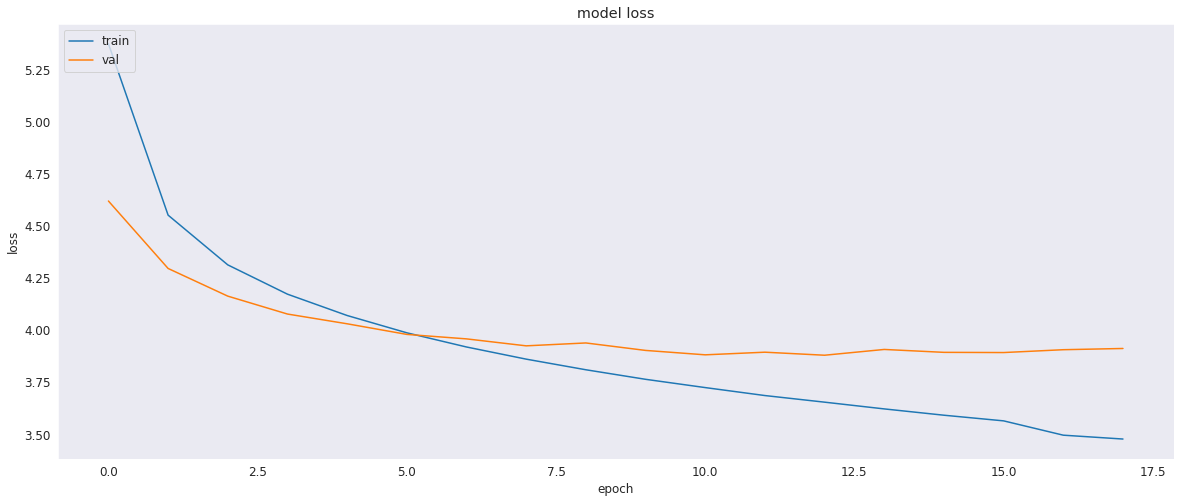

Validation Loss: [4.620065212249756, 4.296175956726074, 4.163298606872559, 4.077332496643066, 4.030520439147949, 3.979541063308716, 3.9580485820770264, 3.9246394634246826, 3.9384844303131104, 3.902663469314575, 3.881483793258667, 3.8941125869750977, 3.8795669078826904, 3.907306432723999, 3.8933792114257812, 3.892406702041626, 3.9060606956481934, 3.9119553565979004]
Training Loss: [5.37551212310791, 4.552227973937988, 4.313425540924072, 4.172752380371094, 4.070276737213135, 3.987208366394043, 3.9191112518310547, 3.860769271850586, 3.80977725982666, 3.7639424800872803, 3.7241806983947754, 3.6859350204467773, 3.654170036315918, 3.621779203414917, 3.591503381729126, 3.5643627643585205, 3.495633840560913, 3.4771370887756348]


In [22]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# In ra giá trị val_loss
print("Validation Loss:", history.history['val_loss'])
# In ra giá trị train_loss
print("Training Loss:", history.history['loss'])

In [23]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [24]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [25]:
test.reset_index(drop=True,inplace=True)
print(test['image'])
print(test['caption'])

0       3601803640_5f3cb05acf.jpg
1       3601803640_5f3cb05acf.jpg
2       3601803640_5f3cb05acf.jpg
3       3601803640_5f3cb05acf.jpg
4       3601803640_5f3cb05acf.jpg
                  ...            
8085     997722733_0cb5439472.jpg
8086     997722733_0cb5439472.jpg
8087     997722733_0cb5439472.jpg
8088     997722733_0cb5439472.jpg
8089     997722733_0cb5439472.jpg
Name: image, Length: 8090, dtype: object
0                   startseq man and woman kissing endseq
1       startseq man and woman kissing in front of cro...
2                    startseq man is kissing woman endseq
3       startseq young couple kiss while crowd mills i...
4              startseq two people kiss near crowd endseq
                              ...                        
8085    startseq man in pink shirt climbs rock face en...
8086    startseq man is rock climbing high in the air ...
8087    startseq person in red shirt climbing up rock ...
8088            startseq rock climber in red shirt endseq
8089 

In [26]:
test['generated_caption'] = ''
for index,record in test.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    generated_caption = predict_caption(model_caption_loaded, record['image'], tokenizer, max_length, features)
    test.loc[index,'generated_caption'] = generated_caption
print(test['generated_caption'])

0       startseq man in red shirt is standing on the s...
1       startseq man in red shirt is standing on the s...
2       startseq man in red shirt is standing on the s...
3       startseq man in red shirt is standing on the s...
4       startseq man in red shirt is standing on the s...
                              ...                        
8085    startseq man in red shirt is standing on the b...
8086    startseq man in red shirt is standing on the b...
8087    startseq man in red shirt is standing on the b...
8088    startseq man in red shirt is standing on the b...
8089    startseq man in red shirt is standing on the b...
Name: generated_caption, Length: 8090, dtype: object


In [27]:
!pip install rouge-score

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=0461661974af5a0fcc3b9368e992c22c698dbcf857b3a3ce118d5be81708a5e3
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [28]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
from rouge_score import rouge_scorer


nltk.download('punkt')

# Assuming test data and generated captions are already available

def calculate_bleu_and_rouge_scores(test_captions, generated_captions):
    # Chuyển đổi test captions và generated captions thành list of lists of words
    references = [[caption.split()] for caption in test_captions]
    hypotheses = [caption.split() for caption in generated_captions]

    # Tính toán BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    # Tính toán ROUGE-2 scores
    rouge_2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
    for ref, hyp in zip(test_captions, generated_captions):
        scores = scorer.score(ref, hyp)
        rouge_2_scores['precision'].append(scores['rouge2'].precision)
        rouge_2_scores['recall'].append(scores['rouge2'].recall)
        rouge_2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

    avg_rouge_2 = {k: np.mean(v) for k, v in rouge_2_scores.items()}

    return bleu1, bleu4, avg_rouge_2['precision'], avg_rouge_2['recall'], avg_rouge_2['fmeasure']

# Sample usage
test_captions = test['caption'].tolist()
generated_captions = test['generated_caption'].tolist()  # Điền vào danh sách các generated captions

bleu1, bleu4, rouge2_precision, rouge2_recall, rouge2_fmeasure = calculate_bleu_and_rouge_scores(test_captions, generated_captions)

print(f"BLEU-1: {bleu1}")
print(f"BLEU-4: {bleu4}")
print(f"ROUGE-2: Precision={rouge2_precision}, Recall={rouge2_recall}, F-measure={rouge2_fmeasure}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
BLEU-1: 0.2958102039760911
BLEU-4: 0.020537247212896913
ROUGE-2: Precision=0.04134122058411305, Recall=0.037980885179454124, F-measure=0.03858603730213566


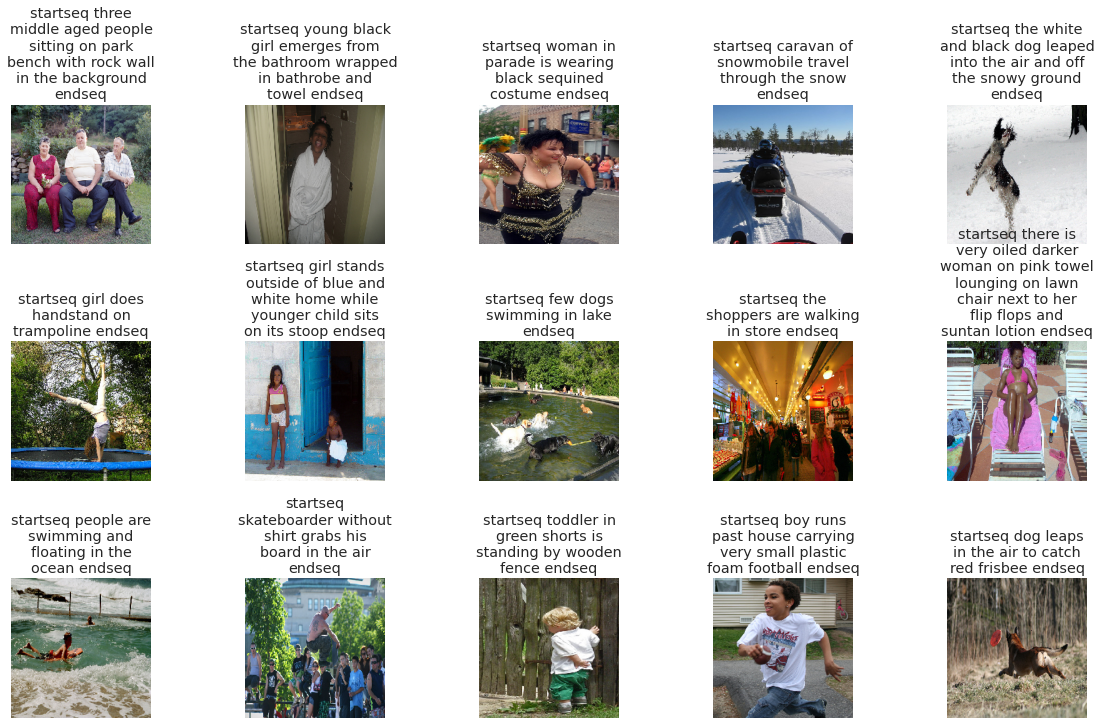

In [29]:
display_images(test.sample(15))